#### Semiconductor manufacturing - wafer fault detection

https://archive.ics.uci.edu/ml/datasets/SECOM

Dataset information:

A complex modern semi-conductor manufacturing process is normally under consistent surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. It is often the case that useful information is buried in the latter two. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs.

To enhance current business improvement techniques the application of feature selection as an intelligent systems technique is being investigated.

The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing, figure 2, and associated date time stamp. Where –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test point.

In [525]:
# import the needed libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


#### Reading and understanding the data

In [688]:
# features
X = pd.read_csv('./data/secom.data', sep=' ', header=None)

# labels
y = pd.read_csv('./data/secom_labels.data', sep=' ', header=None)
y = y.loc[:, [0]]

data = pd.concat([X, y], axis=1)
data.columns.values[-1] = len(data.columns)

cols_with_nulls = [i for i,col_null_sum in enumerate (data.isnull().sum()) if col_null_sum>0]
print(data.info())
print(f'size of the data: {data.shape}')
print(f'number of cells with null values: {sum(data.isnull().sum())}')
print(f'percentage of cells with null values: {round(100 * sum(data.isnull().sum())/data.size, 2)} %')
print(f'number of labels with null values: {sum(y.isnull())}')
print(f'number of columns with null values:{len(cols_with_nulls)}')
print(f'columns with nulls are: {cols_with_nulls}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 591 entries, 0 to 591
dtypes: float64(590), int64(1)
memory usage: 7.1 MB
None
size of the data: (1567, 591)
number of cells with null values: 41951
percentage of cells with null values: 4.53 %
number of labels with null values: 0
number of columns with null values:538
columns with nulls are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 118, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157

In [689]:
# replace the null values with 0 because the missed information may be not available or not calculated
# so replacing it with 0 is more meaningfull than taking the mean value
data = data.replace(np.NaN, 0)

# check again if there are null values
print(f'number of cells with null values: {np.sum(data.isnull().sum())}')


number of cells with null values: 0


#### Balanced dataset or not?

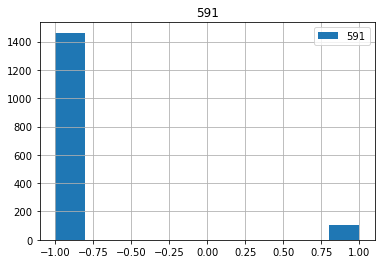

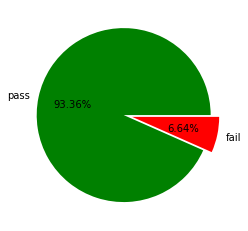

In [528]:
# values of the classes in label column
classes = data[data.columns[-1]].unique()

data.hist(column=data.columns[-1], legend=True)
plt.show()
plt.pie(data[data.columns[-1]].value_counts(), labels=['pass', 'fail'], colors = ['green', 'red'], 
        explode = [0, 0.1], autopct = "%.2f%%")
plt.show()

#### Train and test a model on the data

C:\Users\Pureti\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Pureti\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



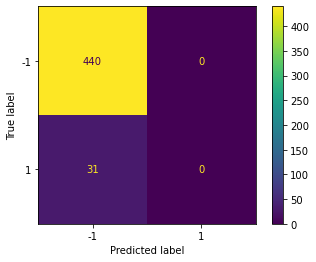

In [529]:
# Splitting the data into independent, dependent, and training and testing datasets
X = data.loc[:, data.columns[:-2]]
y = data.loc[:, data.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# XGB Classifier
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_predict_xgb_clf = xgb_clf.predict(X_test)

# Derive confusion matrix
cm_xgb_clf = confusion_matrix(y_test, y_predict_xgb_clf, labels=xgb_clf.classes_)
ConfusionMatrixDisplay(cm_xgb_clf, display_labels=xgb_clf.classes_).plot(include_values=True)

# predict probabilities, and keep them for the positive outcome only
xgb_clf_prob = xgb_clf.predict_proba(X_test)
xgb_clf_prob = xgb_clf_prob[:, 1]

print(classification_report(y_test, y_predict_xgb_clf))

Recall is zero so there will be room for improvement. Correlation between features provides an information about highly correlated feature that can be removed from the data because they can not contribute much to the model implementation.

#### feature correlation

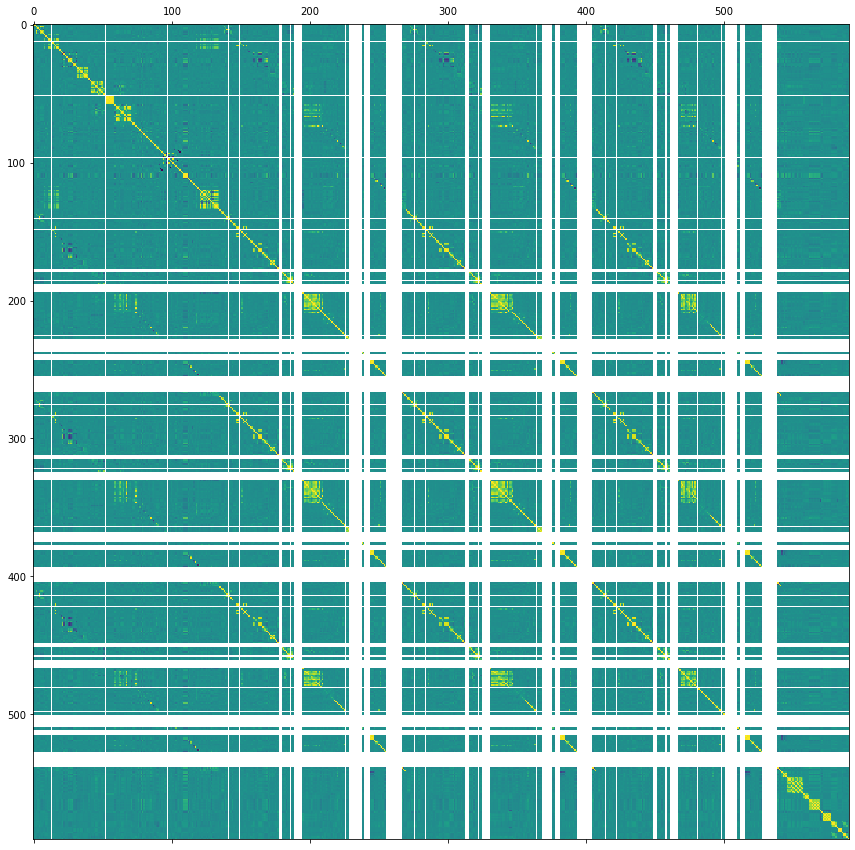

In [530]:
corr_mat = np.array(data.corr())
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(corr_mat)
plt.show()

#### Remove highly correlated features

In [531]:
def remove_highly_corr_cols(data, threshold):
    """
    This function finds correlation between the columns of a dataset and 
    removes the highly correlated columns, which have the correlation higher than a threshold.
    
    Inputs: data , data frame of a dataset.
            threshold, threshold value to define highly correlated columns of the dataset.
            
    Returns: corr_col, highly correlated columns that have the correlation higher than the threshold.
             data, a dataframe with the columns of thier correlation smaller then the threshold.
    """
    corr_col = set()
    corr_mat = data.corr().abs()
    for i in range(corr_mat.shape[1]):
        for j in range(i):
            if (corr_mat.iloc[j, i] > threshold) and (not i==j) and (corr_mat.columns[i] not in corr_col):
                corr_col.add(corr_mat.columns[i])
                data.drop(corr_mat.columns[i], axis='columns', inplace=True)
            
    return corr_col, data


In [532]:
# Find the correlation between the features and remove highly correlated features
corr_threshold = 0.7
corr_cols, data = remove_highly_corr_cols(data, corr_threshold)
print(f'Number of cols which correlation larger than threshold: {len(corr_col)}')
print(f'Highly correlated columns are: {np.array(corr_col)}')
print(f'After dropping the highly correlated columns, the no. of features of the dataset is : {data.shape[1]}')

Number of cols which correlation larger than threshold: 284
Highly correlated columns are: {516, 5, 6, 7, 517, 518, 519, 520, 12, 522, 523, 524, 525, 17, 18, 526, 527, 22, 26, 27, 539, 540, 30, 541, 545, 34, 35, 547, 37, 38, 39, 548, 549, 550, 43, 44, 552, 46, 553, 48, 49, 50, 51, 555, 556, 54, 55, 56, 57, 58, 563, 564, 61, 566, 567, 568, 65, 66, 573, 68, 69, 70, 574, 575, 73, 577, 579, 580, 581, 584, 585, 588, 96, 98, 101, 104, 105, 106, 110, 111, 123, 124, 125, 127, 128, 131, 132, 133, 140, 147, 148, 152, 154, 163, 164, 165, 174, 185, 187, 196, 197, 198, 199, 202, 203, 204, 205, 206, 207, 209, 220, 554, 557, 245, 246, 248, 249, 252, 254, 560, 561, 270, 271, 272, 273, 274, 275, 277, 278, 279, 280, 281, 282, 283, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 316, 317, 318, 319, 320, 321, 323, 324, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 576, 346, 347, 348, 349, 35

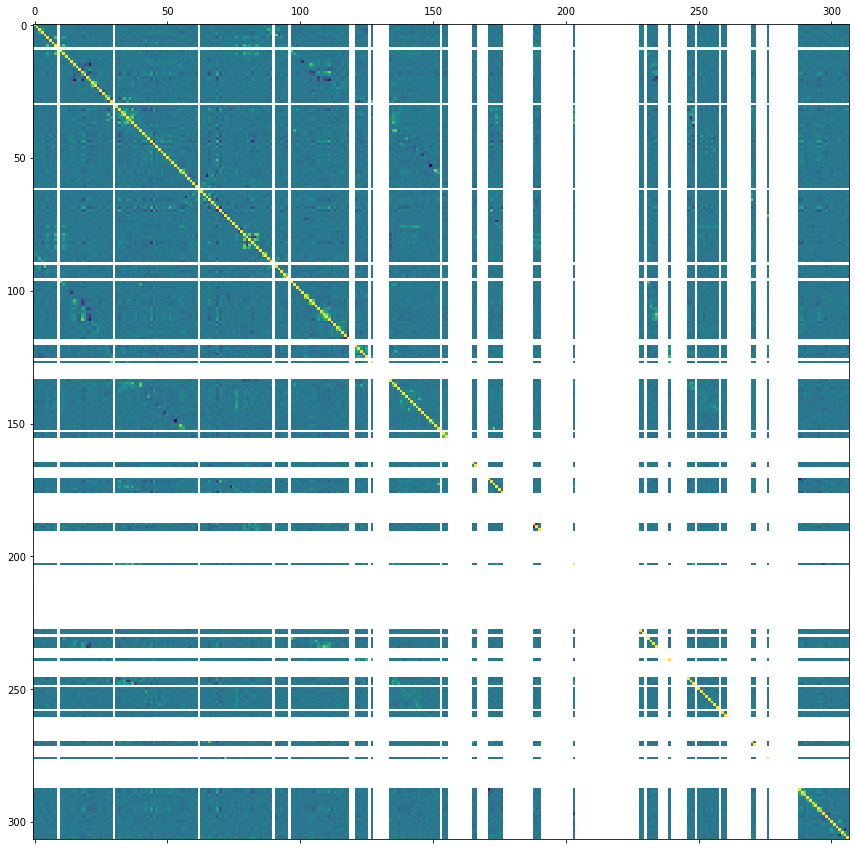

In [533]:
# after removing the highly correlated features
corr_mat = np.array(data.corr())
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(corr_mat)
plt.show()

#### Split the data into dependent and independent, train and test

In [587]:
dataX = data.loc[:, data.columns[:-2]]
datay = data.loc[:, data.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.30, random_state=42)

#### Feature distribution, and feature scaling

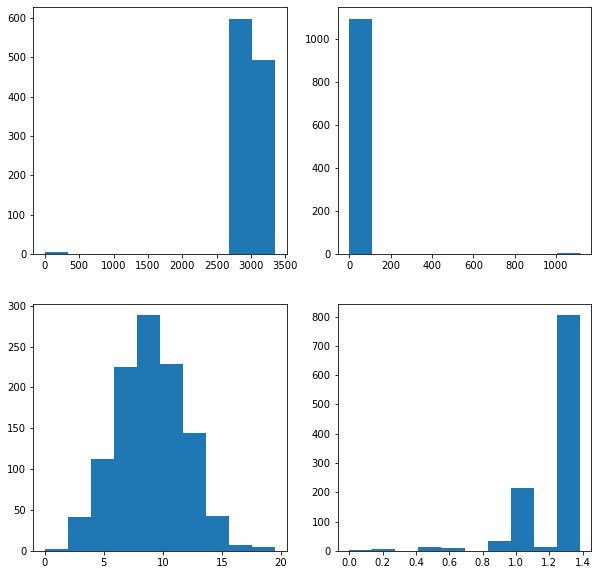

In [535]:
#colnames = X_train.columns.values[np.random.randint(0, X_train.shape[1], size=4)]
colnames = [0, 4, 14, 25]
fig, ax4 = plt.subplots(2, 2, figsize=(10, 10))
for col, ax in zip(colnames,ax4.flatten()):
    ax.hist(X_train[col])
plt.show()

In [536]:
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()

X_train = ssc.fit_transform(X_train)
X_test = ssc.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

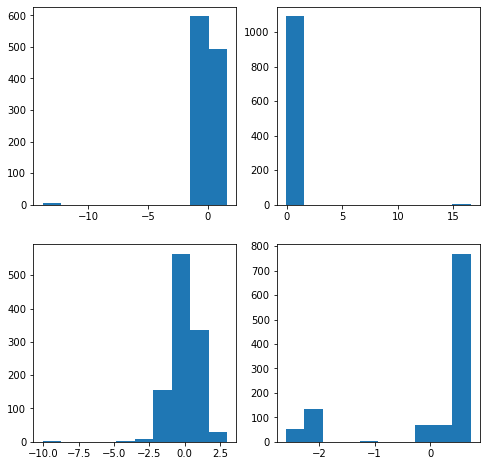

In [537]:
fig, ax4 = plt.subplots(2, 2, figsize=(8, 8))
for col, ax in zip(colnames,ax4.flatten()):
    ax.hist(X_train[col])
plt.show()

#### Logistic Regession classifier

              precision    recall  f1-score   support

          -1       0.95      0.90      0.93       440
           1       0.18      0.29      0.22        31

    accuracy                           0.86       471
   macro avg       0.56      0.60      0.57       471
weighted avg       0.90      0.86      0.88       471



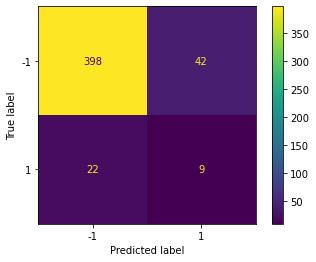

In [497]:
# LogisticRegression Classifier
reg_clf = LogisticRegression(random_state=42, n_jobs=-1)
reg_clf.fit(X_train, y_train)
y_predict_reg_clf = reg_clf.predict(X_test)

# Derive confusion matrix
cm_reg_clf = confusion_matrix(y_test, y_predict_reg_clf, labels=reg_clf.classes_)
ConfusionMatrixDisplay(cm_reg_clf, display_labels=reg_clf.classes_).plot(include_values=True)

"""
# predict probabilities, and keep them for the positive outcome only
reg_clf_prob = reg_clf.predict_proba(X_test)
reg_clf_prob = reg_clf_prob[:, 1]

# precision and recall curve
prec_reg, recall_reg, thres_reg = precision_recall_curve(y_test, reg_clf_prob)
PrecisionRecallDisplay(precision=prec_reg, recall=recall_reg).plot()

# Receiver Operating Characteristic curve
fpr, tpr, _ = roc_curve(y_test, reg_clf_prob)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
"""

print(classification_report(y_test, y_predict_reg_clf))

The recall rate of the failed wafers is ~ 29%, which is very low, on the other hand hand it predicts most of the wafers as good ones. However, the requirement is to predict the failed wafers so high recall rate would be more helpful.

#### Random Forest Classifier

              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



C:\Users\Pureti\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


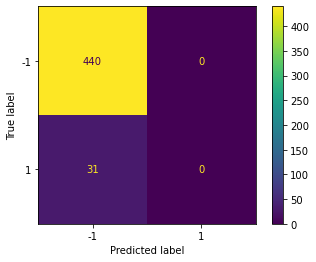

In [498]:
# Random Forest Classifier
rand_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rand_clf.fit(X_train, y_train)
y_predict_rand_clf = rand_clf.predict(X_test)

# Derive confusion matrix
cm_rand_clf = confusion_matrix(y_test, y_predict_rand_clf, labels=rand_clf.classes_)
ConfusionMatrixDisplay(cm_rand_clf, display_labels=rand_clf.classes_).plot(include_values=True)

print(classification_report(y_test, y_predict_rand_clf))

#### XGB Classifier

C:\Users\Pureti\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



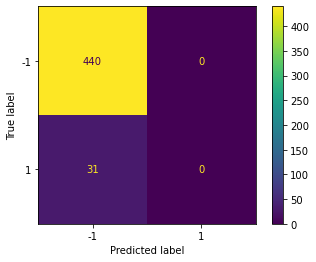

In [499]:
# XGB Classifier
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_predict_xgb_clf = xgb_clf.predict(X_test)

# Derive confusion matrix
cm_xgb_clf = confusion_matrix(y_test, y_predict_xgb_clf, labels=xgb_clf.classes_)
ConfusionMatrixDisplay(cm_xgb_clf, display_labels=xgb_clf.classes_).plot(include_values=True)

print(classification_report(y_test, y_predict_xgb_clf))

#### The prediciton of the failed wafers using the above three models is very small or nil. The primary reason could be imbalanced data. Therefore, we can check whether undersampling or oversampling of the passed and failed cases may improve the performance models.


### Undersampling

- Imbalanced-Learn Library (imlearn) is used to perform the undarsampling.
- Condensed Nearest Neighbor technique is used.
- It choses one-by-one sample and lists them into a store. It only lists the instances (samples) that cannot be classified correctly by the current contents of the store.
- KNN algorithm is used to classify points to determine if they are to be added to the store or not.


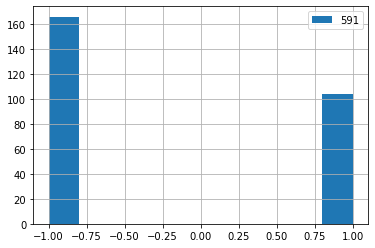

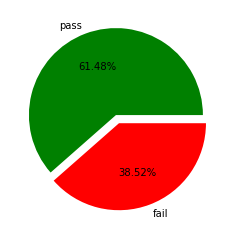

In [543]:
from imblearn.under_sampling import CondensedNearestNeighbour

# define the undersampling method
undersample = CondensedNearestNeighbour(n_neighbors=2)
      
# transform the dataset
X_us, y_us = undersample.fit_resample(dataX, datay)

#Histogram
y_us.hist(legend=True)
plt.show()

#Pie chart
plt.pie(y_us.value_counts(), labels=['pass', 'fail'], colors = ['green', 'red'], 
        explode = [0, 0.1], autopct = "%.2f%%")
plt.show()

In [576]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.30, random_state=42)

X_train_us = ssc.fit_transform(X_train_us)
X_test_us = ssc.transform(X_test_us)

print(f'Shape of the X_train: {X_train_us.shape}')
print(f'Shape of the X_test : {X_test_us.shape}')
print(f'Shape of the y_train: {y_train_us.shape}')
print(f'Shape of the y_test : {y_test_us.shape}')

Shape of the X_train: (189, 305)
Shape of the X_test : (81, 305)
Shape of the y_train: (189,)
Shape of the y_test : (81,)


#### Logistic Regression (Undersampling)

              precision    recall  f1-score   support

          -1       0.68      0.65      0.67        52
           1       0.42      0.45      0.43        29

    accuracy                           0.58        81
   macro avg       0.55      0.55      0.55        81
weighted avg       0.59      0.58      0.58        81



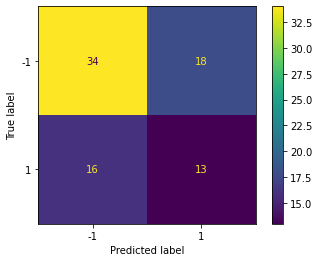

In [577]:
# LogisticRegression Classifier
reg_clf = LogisticRegression(random_state=42, n_jobs=-1)
reg_clf.fit(X_train_us, y_train_us)
y_predict_reg_clf = reg_clf.predict(X_test_us)

# Derive confusion matrix
cm_reg_clf = confusion_matrix(y_test_us, y_predict_reg_clf, labels=reg_clf.classes_)
ConfusionMatrixDisplay(cm_reg_clf, display_labels=reg_clf.classes_).plot(include_values=True)

print(classification_report(y_test_us, y_predict_reg_clf))

#### Random Forest Classsifier (Undersampling)

              precision    recall  f1-score   support

          -1       0.67      0.90      0.77        52
           1       0.55      0.21      0.30        29

    accuracy                           0.65        81
   macro avg       0.61      0.56      0.54        81
weighted avg       0.63      0.65      0.60        81



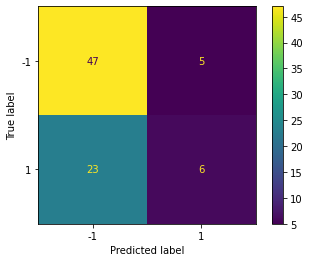

In [578]:
# Random Forest Classifier
rand_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rand_clf.fit(X_train_us, y_train_us)
y_predict_rand_clf = rand_clf.predict(X_test_us)

# Derive confusion matrix
cm_rand_clf = confusion_matrix(y_test_us, y_predict_rand_clf, labels=rand_clf.classes_)
ConfusionMatrixDisplay(cm_rand_clf, display_labels=rand_clf.classes_).plot(include_values=True)

print(classification_report(y_test_us, y_predict_rand_clf))

#### XGB Classifier (Undersampling)

C:\Users\Pureti\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          -1       0.65      0.62      0.63        52
           1       0.38      0.41      0.39        29

    accuracy                           0.54        81
   macro avg       0.51      0.51      0.51        81
weighted avg       0.55      0.54      0.55        81



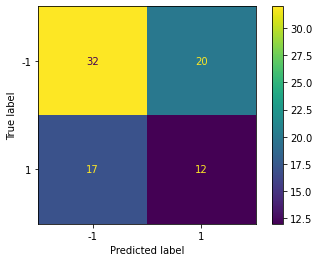

In [579]:
# XGB Classifier
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_us, y_train_us)
y_predict_xgb_clf = xgb_clf.predict(X_test_us)

# Derive confusion matrix
cm_xgb_clf = confusion_matrix(y_test_us, y_predict_xgb_clf, labels=xgb_clf.classes_)
ConfusionMatrixDisplay(cm_xgb_clf, display_labels=xgb_clf.classes_).plot(include_values=True)

print(classification_report(y_test_us, y_predict_xgb_clf))

In [548]:
params = [{'max_depth' : [1, 2, 3, 4, 5, 6],
           'min_child_weight': [3, 4, 5, 6],
           'n_estimators':[500],
           'learning_rate':[0.05, 0.1, 1],
          }]

grid_search = GridSearchCV(estimator = xgb_clf, param_grid = params, scoring = 'accuracy')
grid_search = grid_search.fit(X_train, y_train)
print(f'best score : {grid_search.best_score_}')
print(f'best parameters: {grid_search.best_params_}')

C:\Users\Pureti\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:51:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:51:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:51:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:51:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[06:52:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:52:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:52:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:52:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[06:53:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:53:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:53:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:53:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[06:55:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:55:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:55:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:55:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[06:56:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:56:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:56:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:56:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[06:57:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:57:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:57:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:57:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[06:58:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:58:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:58:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:58:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[06:59:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:59:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:59:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:00:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[07:00:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:00:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:00:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:00:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[07:01:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:01:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:01:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:01:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[07:02:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:02:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:02:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:02:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:55:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          -1       0.61      0.63      0.62        52
           1       0.30      0.28      0.29        29

    accuracy                           0.51        81
   macro avg       0.45      0.46      0.45        81
weighted avg       0.50      0.51      0.50        81



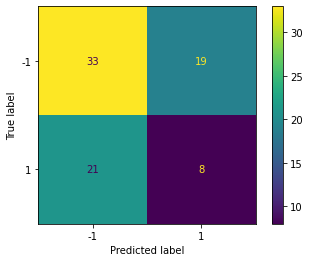

In [580]:
# XGB Classifier
xgb_clf = XGBClassifier(random_state=42, learning_rate=0.05, n_estimators=500, min_child_weight=3, max_depth=3, n_jobs=-1)
xgb_clf.fit(X_train_us, y_train_us)
y_predict_xgb_clf = xgb_clf.predict(X_test_us)

# Derive confusion matrix
cm_xgb_clf = confusion_matrix(y_test_us, y_predict_xgb_clf, labels=xgb_clf.classes_)
ConfusionMatrixDisplay(cm_xgb_clf, display_labels=xgb_clf.classes_).plot(include_values=True)

# predict probabilities, and keep them for the positive outcome only
xgb_clf_prob = xgb_clf.predict_proba(X_test_us)
xgb_clf_prob = xgb_clf_prob[:, 1]

print(classification_report(y_test_us, y_predict_xgb_clf))

With under sampling the recall rate is slightl improved. An alternative method oversampling the minority class instances can be tested.

### Oversampling
- This can be performed using Synthetic Minority Oversampling Technique (SMOTE)
- This apporach synthesizes new examples from the minority class
    - This chooses a random example from minority class
    - Next, finds the nearest neighbouring examples
    - Out of the nearest neighbours, it randomly selects an eaxmple
    - then, between the randomly selected two examples, it creates a random example

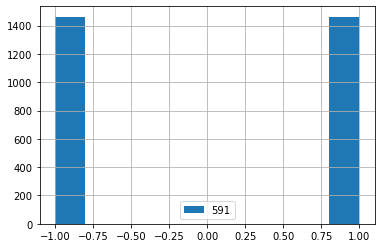

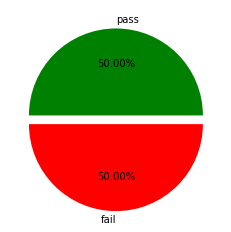

In [550]:
from imblearn.over_sampling import SMOTE

# define the undersampling method
oversample = SMOTE(random_state=42)

# transform the dataset
X_os, y_os = oversample.fit_resample(dataX, datay)

#Histogram
y_os.hist(legend=True)
plt.show()

#Pie chart
plt.pie(y_os.value_counts(), labels=['pass', 'fail'], colors = ['green', 'red'], 
        explode = [0, 0.1], autopct = "%.2f%%")
plt.show()

In [581]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size=0.30, random_state=42)

X_train_os = ssc.fit_transform(X_train_os)
X_test_os = ssc.transform(X_test_os)

print(f'Shape of the X_train: {X_train_os.shape}')
print(f'Shape of the X_test : {X_test_os.shape}')
print(f'Shape of the y_train: {y_train_os.shape}')
print(f'Shape of the y_test : {y_test_os.shape}')

Shape of the X_train: (2048, 305)
Shape of the X_test : (878, 305)
Shape of the y_train: (2048,)
Shape of the y_test : (878,)


#### Logistic Regression (Oversampling)

              precision    recall  f1-score   support

          -1       0.95      0.83      0.89       449
           1       0.84      0.96      0.90       429

    accuracy                           0.89       878
   macro avg       0.90      0.89      0.89       878
weighted avg       0.90      0.89      0.89       878



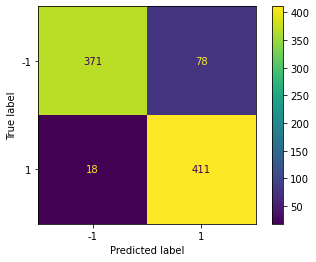

In [582]:
# LogisticRegression Classifier
reg_clf = LogisticRegression(random_state=42, n_jobs=-1)
reg_clf.fit(X_train_os, y_train_os)
y_predict_reg_clf = reg_clf.predict(X_test_os)

# Derive confusion matrix
cm_reg_clf = confusion_matrix(y_test_os, y_predict_reg_clf, labels=reg_clf.classes_)
ConfusionMatrixDisplay(cm_reg_clf, display_labels=reg_clf.classes_).plot(include_values=True)

print(classification_report(y_test_os, y_predict_reg_clf))

#### Random Forest Classifier (Oversampled data)

              precision    recall  f1-score   support

          -1       0.98      0.99      0.99       449
           1       0.99      0.98      0.99       429

    accuracy                           0.99       878
   macro avg       0.99      0.99      0.99       878
weighted avg       0.99      0.99      0.99       878



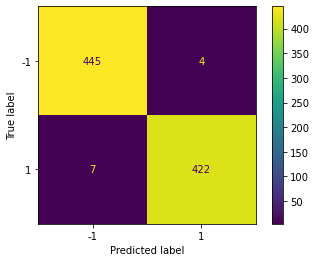

In [583]:
# Random Forest Classifier
rand_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rand_clf.fit(X_train_os, y_train_os)
y_predict_rand_clf = rand_clf.predict(X_test_os)

# Derive confusion matrix
cm_rand_clf = confusion_matrix(y_test_os, y_predict_rand_clf, labels=rand_clf.classes_)
ConfusionMatrixDisplay(cm_rand_clf, display_labels=rand_clf.classes_).plot(include_values=True)

print(classification_report(y_test_os, y_predict_rand_clf))

#### XGB Classifier (Oversampled data)

C:\Users\Pureti\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          -1       0.97      0.98      0.97       449
           1       0.98      0.97      0.97       429

    accuracy                           0.97       878
   macro avg       0.97      0.97      0.97       878
weighted avg       0.97      0.97      0.97       878



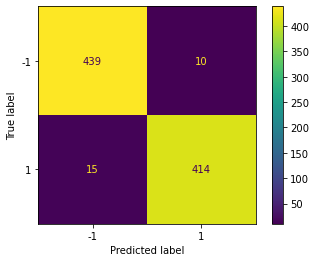

In [584]:
# XGB Classifier
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_os, y_train_os)
y_predict_xgb_clf = xgb_clf.predict(X_test_os)

# Derive confusion matrix
cm_xgb_clf = confusion_matrix(y_test_os, y_predict_xgb_clf, labels=xgb_clf.classes_)
ConfusionMatrixDisplay(cm_xgb_clf, display_labels=xgb_clf.classes_).plot(include_values=True)

print(classification_report(y_test_os, y_predict_xgb_clf))

<b> The (above) models based on the over sampled data improved the recall rate significantly. Random forest classifier provides the highest accuracy among the three models. </b>

#### Let's use the model on the test instances data by sacling the data with the parameters that are derived from the scalin of the oversampled data

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       440
           1       0.94      0.94      0.94        31

    accuracy                           0.99       471
   macro avg       0.97      0.97      0.97       471
weighted avg       0.99      0.99      0.99       471



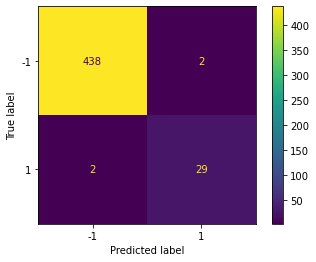

In [592]:
_, X_test_1, _, y_test_1 = train_test_split(dataX, datay, test_size=0.30, random_state=42)

X_test_1 = ssc.transform(X_test_1)

y_predict_rand_clf = rand_clf.predict(X_test_1)

cm_rand_clf = confusion_matrix(y_test_1, y_predict_rand_clf, labels=rand_clf.classes_)
ConfusionMatrixDisplay(cm_rand_clf, display_labels=rand_clf.classes_).plot(include_values=True)

print(classification_report(y_test_1, y_predict_rand_clf))

# Dimensionality reduction using PCA

In [593]:
from sklearn.decomposition import PCA


In [606]:
# features
X = pd.read_csv('./data/secom.data', sep=' ', header=None)

# labels
y = pd.read_csv('./data/secom_labels.data', sep=' ', header=None)
y = y.loc[:, [0]]

data = pd.concat([X, y], axis=1)
data.columns.values[-1] = len(data.columns)

# replace the None values with 0s
data = data.replace(np.NaN, 0)

X_pca = data.loc[:, data.columns[:-2]]
y_pca = data.loc[:, data.columns[-1]]

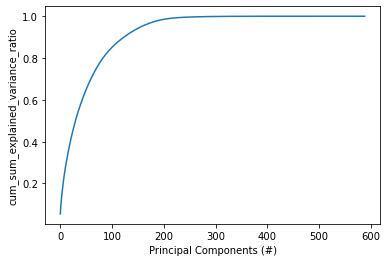

The number of PCs that contribute cumulative varivance 0.95: 156


In [649]:
# Centralise the data
X_pca_1 = X_pca.copy()
X_pca_1 = ssc.fit_transform(X_pca_1)

# model and fitting
pca = PCA(n_components=X_pca_1.shape[1])
X_reduced = pca.fit_transform(X_pca_1)

# cumulative sum of explained variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)

# plotting the principal components verses the cumulative sum of variance
fig, ax = plt.subplots()
ax.plot(np.arange(len(cumsum)), cumsum)
ax.set(xlabel='Principal Components (#)', ylabel='cum_sum_explained_variance_ratio')
plt.show()

# the number of components that contribute most to the dataset
cum_var_thr = 0.95
n_pc = np.where(cumsum>=cum_var_thr)[0][0]
print(f'The number of PCs that contribute cumulative varivance {cum_var_thr}: {n_pc}')

### PCA for machine learning algorithms

In [645]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.30, random_state=42)

# scale the data
ssc.fit(X_train_pca)

X_train_pca = ssc.transform(X_train_pca)
X_test_pca = ssc.transform(X_test_pca)

# find the principal components
pca = PCA(n_components=cum_var_thr)
pca.fit(X_train_pca)

X_train_pca = pca.transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

print(f'Shape of the X_train_pca: {X_train_pca.shape}')
print(f'Shape of the X_test_pca: {X_test_pca.shape}')

Shape of the X_train_pca: (1096, 152)
Shape of the X_test_pca: (471, 152)


#### Logistic Regression (Principal components)

              precision    recall  f1-score   support

          -1       0.95      0.95      0.95       440
           1       0.31      0.29      0.30        31

    accuracy                           0.91       471
   macro avg       0.63      0.62      0.63       471
weighted avg       0.91      0.91      0.91       471



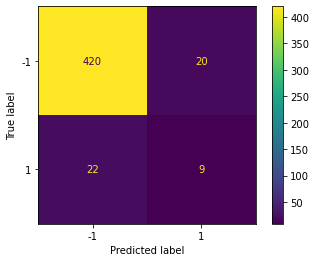

In [646]:
# LogisticRegression Classifier
reg_clf = LogisticRegression(random_state=42, n_jobs=-1)
reg_clf.fit(X_train_pca, y_train_pca)
y_predict_reg_clf = reg_clf.predict(X_test_pca)

# Derive confusion matrix
cm_reg_clf = confusion_matrix(y_test_pca, y_predict_reg_clf, labels=reg_clf.classes_)
ConfusionMatrixDisplay(cm_reg_clf, display_labels=reg_clf.classes_).plot(include_values=True)

print(classification_report(y_test_pca, y_predict_reg_clf))

#### Random Forest Classifier (Principal Components)

              precision    recall  f1-score   support

          -1       0.94      0.99      0.96       440
           1       0.38      0.10      0.15        31

    accuracy                           0.93       471
   macro avg       0.66      0.54      0.56       471
weighted avg       0.90      0.93      0.91       471



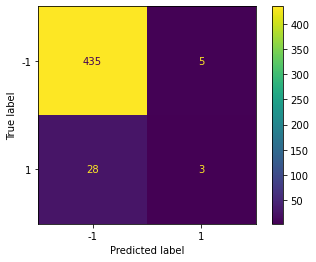

In [647]:
# Random Forest Classifier
rand_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rand_clf.fit(X_train_pca, y_train_pca)
y_predict_rand_clf = rand_clf.predict(X_test_pca)

# Derive confusion matrix
cm_rand_clf = confusion_matrix(y_test_pca, y_predict_rand_clf, labels=rand_clf.classes_)
ConfusionMatrixDisplay(cm_rand_clf, display_labels=rand_clf.classes_).plot(include_values=True)

print(classification_report(y_test_pca, y_predict_rand_clf))

#### XGB Classifier (Principal Components)

C:\Users\Pureti\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



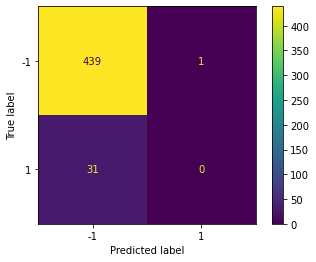

In [648]:
# XGB Classifier
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_pca, y_train_pca)
y_predict_xgb_clf = xgb_clf.predict(X_test_pca)

# Derive confusion matrix
cm_xgb_clf = confusion_matrix(y_test_pca, y_predict_xgb_clf, labels=xgb_clf.classes_)
ConfusionMatrixDisplay(cm_xgb_clf, display_labels=xgb_clf.classes_).plot(include_values=True)

print(classification_report(y_test_pca, y_predict_xgb_clf))

#### Oversample the Principal components

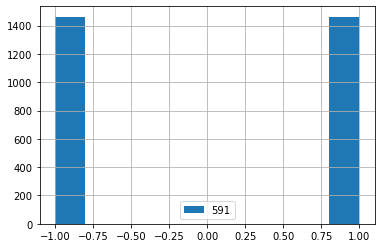

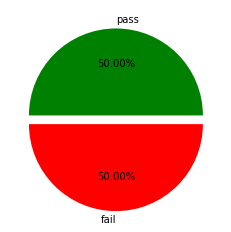

In [650]:
# define the undersampling method
oversample = SMOTE(random_state=42)

# transform the dataset
X_pca_os, y_pca_os = oversample.fit_resample(X_pca, y_pca)

#Histogram
y_pca_os.hist(legend=True)
plt.show()

#Pie chart
plt.pie(y_pca_os.value_counts(), labels=['pass', 'fail'], colors = ['green', 'red'], 
        explode = [0, 0.1], autopct = "%.2f%%")
plt.show()

In [651]:
X_train_pca_os, X_test_pca_os, y_train_pca_os, y_test_pca_os = train_test_split(X_pca_os, y_pca_os, test_size=0.30, random_state=42)

X_train_pca_os = ssc.fit_transform(X_train_pca_os)
X_test_pca_os = ssc.transform(X_test_pca_os)

#### Logistic Regression (Oversampled PCA)

              precision    recall  f1-score   support

          -1       0.99      0.82      0.90       449
           1       0.84      0.99      0.91       429

    accuracy                           0.90       878
   macro avg       0.91      0.90      0.90       878
weighted avg       0.91      0.90      0.90       878



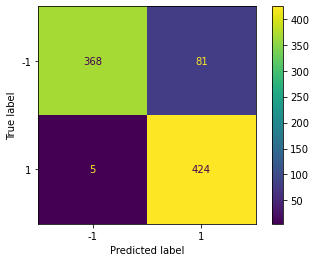

In [654]:
# LogisticRegression Classifier
reg_clf = LogisticRegression(random_state=42, n_jobs=-1)
reg_clf.fit(X_train_pca_os, y_train_pca_os)
y_predict_reg_clf = reg_clf.predict(X_test_pca_os)

# Derive confusion matrix
cm_reg_clf = confusion_matrix(y_test_pca_os, y_predict_reg_clf, labels=reg_clf.classes_)
ConfusionMatrixDisplay(cm_reg_clf, display_labels=reg_clf.classes_).plot(include_values=True)

print(classification_report(y_test_pca_os, y_predict_reg_clf))

#### Random Forest Classifier (Oversampled PCA)

              precision    recall  f1-score   support

          -1       0.98      0.99      0.99       449
           1       0.99      0.98      0.98       429

    accuracy                           0.99       878
   macro avg       0.99      0.99      0.99       878
weighted avg       0.99      0.99      0.99       878



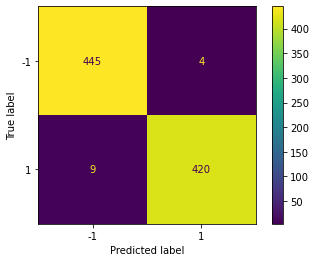

In [655]:
# Random Forest Classifier
rand_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rand_clf.fit(X_train_pca_os, y_train_pca_os)
y_predict_rand_clf = rand_clf.predict(X_test_pca_os)

# Derive confusion matrix
cm_rand_clf = confusion_matrix(y_test_pca_os, y_predict_rand_clf, labels=rand_clf.classes_)
ConfusionMatrixDisplay(cm_rand_clf, display_labels=rand_clf.classes_).plot(include_values=True)

print(classification_report(y_test_pca_os, y_predict_rand_clf))

#### XGB Classifier (Oversampled PCA)

C:\Users\Pureti\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:22:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          -1       0.98      0.98      0.98       449
           1       0.98      0.97      0.98       429

    accuracy                           0.98       878
   macro avg       0.98      0.98      0.98       878
weighted avg       0.98      0.98      0.98       878



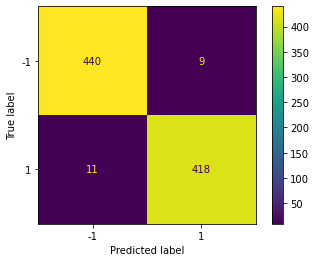

In [656]:
# XGB Classifier
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_pca_os, y_train_pca_os)
y_predict_xgb_clf = xgb_clf.predict(X_test_pca_os)

# Derive confusion matrix
cm_xgb_clf = confusion_matrix(y_test_pca_os, y_predict_xgb_clf, labels=xgb_clf.classes_)
ConfusionMatrixDisplay(cm_xgb_clf, display_labels=xgb_clf.classes_).plot(include_values=True)

print(classification_report(y_test_pca_os, y_predict_xgb_clf))

The (above) models based on the over sampled principal components are providing almost the same observations using the oversampled data. Random forest classifier provides the highest accuracy among the three models

### Feature Importance
- Derived it from the oversampled data using random forest model

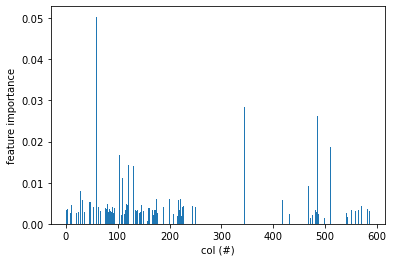

Top 3 important feature for rand forest models are : [ 59 112 345]


In [712]:
rand_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rand_clf.fit(X_train_os, y_train_os)
fi = rand_clf.feature_importances_

fig, ax = plt.subplots()
ax.bar(dataX.columns.values, fi)
ax.set(xlabel='col (#)', ylabel='feature importance')
plt.show()

cols_fi = dataX.columns.values[fi.argsort()][::-1]

print(f'Top 3 important feature for rand forest models are : {cols_fi[:3]}')

### Summary
- Different models are trained to the data that is scaled and shortened.
- Having class baisedness in the data, the models could not provide even decent racall accuracy
- Undersamling and oversampling techniques are used to improve the racall accuracy of the models
    - While there is a little improvement in the recall acuuracy with the undersampling, a significant improvement is observed for the oversampled data
    - Random forest and XGB models provided highest accuracies (up to 97 - 99%)
- PCA model is used to extract the more contributing features with a threshold (0.95) in the cumulative sum of the variance
    - Extracted principal components number is 152
    - Different models are trained on the principle components
        - These models have alomost the same accurancies of the models trained with the normal data
        - Oversample components provided the same accuracies of the models trained with the oversampled normal data
- The most important features for random forest model are 59, 112, and 345.        
